# Importing the libraries
In this part, we are importing the libraries we need.

In [132]:
# Importing files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import sys
import glob
import datetime
import calendar
import csv

# Spark imports
from pyspark.rdd import RDD
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc
from pyspark.sql.functions import col, asc, desc, split

# used to check if the array has a value
from pyspark.sql.functions import array_contains

# used for the encoding of categories
from sklearn.preprocessing import MultiLabelBinarizer

# used for cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity

# Used for the indexes in content-based part
from pyspark.sql.window import Window

# Spark 
In this project, we are using apache spark as well as Pandas.

In [2]:
# Initialize a spark session.
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

In [3]:
spark = init_spark() # Initializate spark

# Buisiness dataset 
The first dataset is buisiness dataset. We are importing the dataset to work with the features and extract user and profile items.

In [4]:
# Loading the business.json in spark 
path = 'data/yelp_academic_dataset_business.json'
df_business = spark.read.json(path)

In [5]:
# Print informations about the business dataset
df_business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

## Filtering restaurant businesses
Now we want to filter the Restaurant category from the dataset

In [6]:
df_business_filtered = df_business.filter(df_business.categories.contains('Restaurants'))  # Filter only restaurants

In [7]:
# Checking if there are null values
print('Number of null values in categories:')
df_business_filtered.filter(df_business_filtered.categories.isNull()).count()

Number of null values in categories:


0

In [241]:
from pyspark.sql.functions import regexp_replace, col, lower
df_business_filtered.select('categories').show(5, truncate=False)  # Before fixing
df_business_filtered = df_business_filtered.withColumn('categories', regexp_replace(col('categories'), " ", ""))  # Remove spaces
df_business_filtered = df_business_filtered.withColumn('categories', lower(col('categories')))  # Convert to lower letters
df_business_filtered.select('categories').show(5, truncate=False)  # After fixing

+-------------------------------------------------------------------+
|categories                                                         |
+-------------------------------------------------------------------+
|restaurants,food,bubbletea,coffee&tea,bakeries                     |
|burgers,fastfood,sandwiches,food,icecream&frozenyogurt,restaurants |
|pubs,restaurants,italian,bars,american(traditional),nightlife,greek|
|icecream&frozenyogurt,fastfood,burgers,restaurants,food            |
|vietnamese,food,restaurants,foodtrucks                             |
+-------------------------------------------------------------------+
only showing top 5 rows

+-------------------------------------------------------------------+
|categories                                                         |
+-------------------------------------------------------------------+
|restaurants,food,bubbletea,coffee&tea,bakeries                     |
|burgers,fastfood,sandwiches,food,icecream&frozenyogurt,restauran

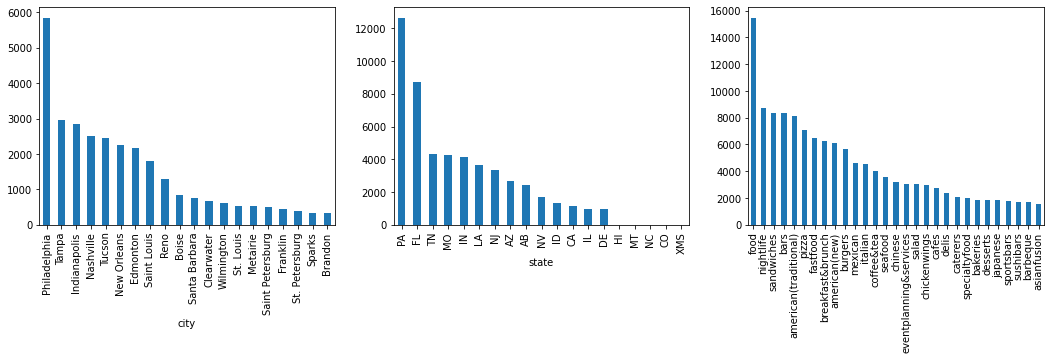

In [242]:
# Some interesting plot to know the data

df_business_pd = df_business_filtered.toPandas()

fig = plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
df_bus_count1 = df_business_pd.groupby('city').count()
df_bus_city = df_bus_count1['name']
df_bus_city_sorted = df_bus_city.sort_values(ascending = False)
df_bus_city_sorted[:20].plot(kind = 'bar')

plt.subplot(1, 3, 2)
df_bus_count2 = df_business_pd.groupby('state').count()
df_bus_state = df_bus_count2['name']
df_bus_state_sorted = df_bus_state.sort_values(ascending = False)
df_bus_state_sorted[:20].plot(kind = 'bar')

plt.subplot(1, 3, 3)
uniq_cat_dict = {}
for i in df_business_pd.categories:
    cat = str(i).replace(" ", "").split(',')
    for j in cat:
        if j not in uniq_cat_dict.keys():
            uniq_cat_dict[j] = 1
        else:
            uniq_cat_dict[j] += 1
uniq_cat_series = pd.Series(uniq_cat_dict)
uniq_cat_series.sort_values(ascending = False, inplace = True)
uniq_cat_series[1:30].plot(kind = 'bar') # Not printing the category restaurant


_ = plt.plot

In [10]:
# Printing the categories
uniq_cat_series

restaurants                52268
food                       15472
nightlife                   8723
sandwiches                  8366
bars                        8337
                           ...  
hometheatreinstallation        1
homeownerassociation           1
kidshairsalons                 1
calabrian                      1
gemstones&minerals             1
Length: 728, dtype: int64

## Now we want to encode the field called categories

In [243]:
mlb = MultiLabelBinarizer()

#create boolean mask matched non NaNs values
mask = df_business_pd['categories'].notnull()

#filter by boolean indexing
arr = mlb.fit_transform(df_business_pd.loc[mask, 'categories'].dropna().str.strip('[]').str.split(','))

#create DataFrame and add missing (NaN)s index values
df_categories = (pd.DataFrame(arr, index=df_business_pd.index[mask], columns=mlb.classes_)
               .reindex(df_business_pd.index, fill_value=0))

df_categories.sort_index().head(10)

,acaibowls,accessories,accountants,activelife,acupuncture,adult,adulteducation,adultentertainment,advertising,afghan,...,winebars,wineries,winetastingclasses,winetastingroom,winetours,women'sclothing,wraps,yelpevents,yoga,zoos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


### Preprocessing the cities: 
After the preprocessing, the number of unique cities dropped. 

In [244]:
df_business_pd = df_business_pd.sort_values(by=['city'])  # Sorting by name
print('Original unique city values:', len(df_business_pd['city'].unique()))  # Printing the unique values
df_business_pd['city'] = df_business_pd['city'].str.lower()
print('Unique city values after changing all letter to lowercase:', len(df_business_pd['city'].unique())) # Printing the unique values

Original unique city values: 920
Unique city values after changing all letter to lowercase: 859


### Encoding the city and state

In [245]:
# Encoding feature City and State features
df_city = pd.get_dummies(df_business_pd.city).sort_index()
df_state = pd.get_dummies(df_business_pd.state).sort_index()
df_city.head(10) # printing for state (example)

,abington,abington township,affton,aldan,algiers,alloway,alton,ambler,antioch,apollo beach,...,wycombe,wyncote,wyndlake condominium,wyndmoor,wynnewood,yardley,yeadon,zephyrhills,zieglerville,zionsville
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [246]:
# Sorting by index for better visualization
df_restData = df_business_pd[['business_id', 'latitude','longitude','stars','is_open']].sort_index()

In [247]:
# Creating the item profile with all pre-processed enconded item features
frames = [df_restData, df_categories, df_city, df_state]
df_itemProf = pd.concat(frames, axis=1)
df_itemProf.sort_index().head(10)

,business_id,latitude,longitude,stars,is_open,acaibowls,accessories,accountants,activelife,acupuncture,...,IN,LA,MO,MT,NC,NJ,NV,PA,TN,XMS
0,MTSW4McQd7CbVtyjqoe9mw,39.955505,-75.155564,4.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,CF33F8-E6oudUQ46HnavjQ,36.269593,-87.058943,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,k0hlBqXX-Bt0vf1op7Jr1w,38.565165,-90.321087,3.0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,bBDDEgkFA1Otx9Lfe7BZUQ,36.208102,-86.768170,1.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,eEOYSgkmpB90uNA7lDOMRA,27.955269,-82.456320,4.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,il_Ro8jwPlHresjw9EGmBg,39.637133,-86.127217,2.5,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
6,0bPLkL0QhhPO5kt1_EXmNQ,27.916116,-82.760461,4.5,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,MUTTqe8uqyMdBl186RmNeA,39.953949,-75.143226,4.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8,ROeacJQwBeh05Rqg7F6TCg,39.943223,-75.162568,4.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9,WKMJwqnfZKsAae75RMP6jA,53.546045,-113.499169,4.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [248]:
# Apply normalization technique to Column 1, Column 2 and Column 3
df_itemProf_normalized = df_itemProf.copy()

from sklearn import preprocessing
cont = 0
for col in df_itemProf_normalized.columns[1:]:
    print(col)
    min_max_scaler = preprocessing.MinMaxScaler()
    df_itemProf_normalized[[col]] = min_max_scaler.fit_transform(df_itemProf_normalized[[col]])
    if cont == 2:
        break
    cont = cont + 1

latitude
longitude
stars


In [249]:
# View normalized data
df_itemProf_normalized

,business_id,latitude,longitude,stars,is_open,acaibowls,accessories,accountants,activelife,acupuncture,...,IN,LA,MO,MT,NC,NJ,NV,PA,TN,XMS
0,MTSW4McQd7CbVtyjqoe9mw,0.474485,0.989187,0.750,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,CF33F8-E6oudUQ46HnavjQ,0.333342,0.727110,0.250,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,k0hlBqXX-Bt0vf1op7Jr1w,0.421245,0.655287,0.500,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,bBDDEgkFA1Otx9Lfe7BZUQ,0.330987,0.733512,0.125,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,eEOYSgkmpB90uNA7lDOMRA,0.014965,0.828446,0.750,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52263,l9eLGG9ZKpLJzboZq-9LRQ,0.473342,0.985779,0.500,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
52264,cM6V90ExQD6KMSU3rRB5ZA,0.614632,0.083644,0.750,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
52265,WnT9NIzQgLlILjPT0kEcsQ,0.473737,0.989119,0.875,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
52266,2O2K6SXPWv56amqxCECd4w,0.470682,0.983195,0.875,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [250]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.95)  # Typically, we want the explained variance to be between 95–99%
# principalComponents = pca.fit_transform(df_itemProf_normalized.iloc[:,1:])
# df_itemProf_normalized_pca = pd.DataFrame(data = principalComponents)

In [251]:
# df_itemProf_normalized_pca.insert(0, 'business_id', df_itemProf_normalized['business_id'])

In [252]:
# df_itemProf_normalized = df_itemProf_normalized_pca

In [253]:
# df_itemProf_normalized

# Loading the 'review' dataset
The third dataset regards the Review' information

In [22]:
# Loading the review file
path = 'data/yelp_academic_dataset_review.json'
df_review = spark.read.json(path)

In [23]:
# Print the number of rows and columns
print((df_review.count(), len(df_review.columns)))

(6990280, 9)


In [24]:
#Printing the columns' name
df_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [25]:
df_review = df_review[['business_id','user_id','stars']]
df_review.show(10)

+--------------------+--------------------+-----+
|         business_id|             user_id|stars|
+--------------------+--------------------+-----+
|XQfwVwDr-v0ZS3_Cb...|mh_-eMZ6K5RLWhZyI...|  3.0|
|7ATYjTIgM3jUlt4UM...|OyoGAe7OKpv6SyGZT...|  5.0|
|YjUWPpI6HXG530lwP...|8g_iMtfSiwikVnbP2...|  3.0|
|kxX2SOes4o-D3ZQBk...|_7bHUi9Uuf5__HHc_...|  5.0|
|e4Vwtrqf-wpJfwesg...|bcjbaE6dDog4jkNY9...|  4.0|
|04UD14gamNjLY0IDY...|eUta8W_HdHMXPzLBB...|  1.0|
|gmjsEdUsKpj9Xxu6p...|r3zeYsv1XFBRA4dJp...|  5.0|
|LHSTtnW3YHCeUkRDG...|yfFzsLmaWF2d4Sr0U...|  5.0|
|B5XSoSG3SfvQGtKEG...|wSTuiTk-sKNdcFypr...|  3.0|
|gebiRewfieSdtt17P...|59MxRhNVhU9MYndMk...|  3.0|
+--------------------+--------------------+-----+
only showing top 10 rows



In [26]:
# Filtering REVIEWS file by only RESTAURANTS identified with the RESTAURANT in 'categories'
df_review1 = df_review.join(df_business_filtered[['business_id']], df_review.business_id == df_business_filtered.business_id ,"left_semi")
df_review1.count()

4724471

In [209]:
# Creating an auxiliar df to filter only user with more than 50 reviews
df_count_reviews = df_review1.groupBy("user_id").count() # Creating a df with the number of reviews per user
df_count_reviews1 = df_count_reviews.filter(col("count") >= 50)  # Filtering only users with more than 50 reviews
df_count_reviews1.show(10, truncate=False)

+----------------------+-----+
|user_id               |count|
+----------------------+-----+
|IeSz60ozr1yAVIH8CX9w9w|149  |
|FlXBpK_YZxLo27jcMdII1w|489  |
|Zsdee1KEpMwjg5cqx-VWrQ|56   |
|9WuP-4jfndovEFJ4bpt5vA|62   |
|SSafXe2aUO0cXgQhEdtzrA|104  |
|4PE0tDvV9Lo8VW8kDW1SFQ|83   |
|LnFIWZM_l__4t8Qxj3pnOg|418  |
|dioXbYFdMCyE7zCK90eM3Q|133  |
|_LT9U6nhRgny5folsaTxPA|75   |
|cbY0f25GE3WLB5YUNQUgtw|74   |
+----------------------+-----+
only showing top 10 rows



In [42]:
review_count = df_count_reviews1.select('count').rdd.flatMap(lambda x: x).collect()

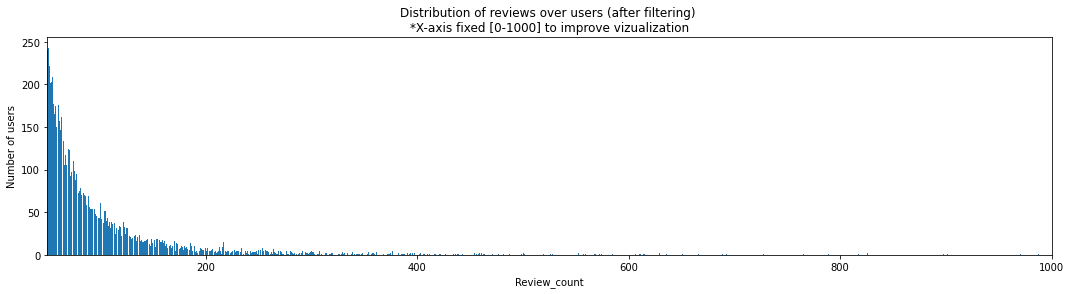

In [43]:
# Printing the distribution
fig = plt.figure(figsize=(18, 4))
plt.hist(review_count, bins=2000)
plt.xlim([50, 1000])
plt.title('Distribution of reviews over users (after filtering) \n*X-axis fixed [50-1000] to improve vizualization')
plt.xlabel('Review_count')
plt.ylabel('Number of users')
_ = plt.plot

In [210]:
# Filtering REVIEWS by only users identified with >= 50 REVIEWS
df_review2 = df_review1.join(df_count_reviews1, df_review1.user_id == df_count_reviews1.user_id ,"left_semi")
df_review2.count()

801411

In [29]:
# Printing how many Null files each categorie have
for i in df_review2.columns:
    print(i, df_review2.filter(col(i).isNull()).count())

business_id 0
user_id 0
stars 0


In [255]:
# Putting stars in a list to be used in the next plot
stars_list = [row[0] for row in df_review2.select('stars').collect()]

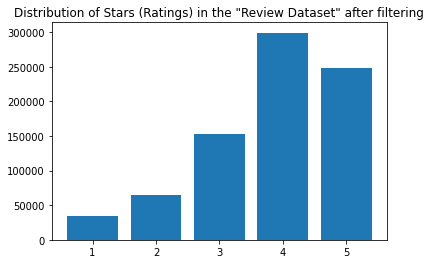

In [256]:
# Printing the distribution of STARS (RESTAURANTS RATINGS)
from collections import Counter
c = Counter(stars_list)
plt.bar(c.keys(), c.values())
plt.title('Distribution of Stars (Ratings) in the "Review Dataset" after filtering')
plt.show()

# Building and Evaluating our Content-Based Recommendation System
Here we implement and evaluate our Content-Based Recommendation System

Note: For the evaluation we used the precision@k approach with k = 5 and items with rating 4 or 5 are considered RELEVANT

In [229]:
def preparing_data(user_id_value, df_review, training_split):
    """
    This function prepares the data to be evaluated in our Content-Based Recommendation System. 
    It receives the whole df_review dataset, filter by a given user and divide into training and test set
    """
    df_user_f = df_review.filter(df_review.user_id == user_id_value)  # Filtering the review file just for the user
    df_user_f = df_user_f.dropDuplicates(['business_id'])  # Remove cases when user reviewed the same restaurant two times
    [train, test] = df_user_f.randomSplit([training_split, 1-training_split], seed = 0) # Splitting the dataset into train and test
    return train, test

In [230]:
def return_stars(user_id_value, train):
    """
    This function create a vector of ratings for a given user using ONLY the train set
    """
    df_temp1 = pd.merge(df_itemProf_normalized[['business_id']], train, on='business_id', how="left") # Finding ratings for all items for the user (NaN) is returned for non reted items
    np_stars = df_temp1['stars'].to_numpy()
    np_stars[np.isnan(np_stars)] = 0
    return np_stars

In [231]:
def build_user_profile(user_id_value, train):
    """
    This function creates the user_profile given the user and the TRAIN SER
    """
    np_stars = return_stars(user_id_value, train)  # Using the function return_stars to form a vector with all restaurants reviwed 
    np_items_matrix1 = np.array(df_itemProf_normalized.iloc[:,1:]) # dropping business ID column from item profile df and trsansformin np.array
    user_profile = (np.matmul(np_stars.transpose(), np_items_matrix1))/np.sum(np_stars)
    return user_profile

In [232]:
def content_based_test(user_profile, k_value, test):
    """
    This function uses the user_profile and calculate the K most recommended items in the TEST SET
    """
    business_list = [row[0] for row in test.select('business_id').collect()]
    
    df_itemProf1 = df_itemProf_normalized[df_itemProf_normalized['business_id'].isin(business_list)]
    np_items_matrix1 = np.array(df_itemProf1.iloc[:,1:])  # transform to np.array and do not consider first column
    similarity = cosine_similarity(user_profile.reshape(1, -1), np_items_matrix1[:])  # find the cosine_similarity
    indices = (-similarity[0]).argsort()[:k_value] # Returning the position of the K highest similarities found for a given user
    return df_itemProf1['business_id'].to_numpy()[np.array([indices])]  # Return the list of business_id most similar

In [233]:
def precision_at_k(array_business, test, treshold_score):
    """
    This function calculate the precision@k. Note that the treshold score defines if the item is relevant or not.
    """
    k_value = len(array_business)
    test = test[test['business_id'].isin(array_business)]
    array_score = test['stars'].to_numpy()
    precision_k = np.sum(array_score>=treshold_score)/k_value # return precision score (in %)
    return precision_k, array_score

In [234]:
def detailed_results(array_business, array_score):
    """
    This function print the detailed results
    """
    df_results = df_business_pd[df_business_pd['business_id'].isin(array_business)]
    df_results = df_results[['name', 'categories']]
    df_results['real_scores'] = array_score
    return df_results

In [37]:
###################################################################
####################### SIMULATION ################################
###################################################################

In [227]:
#user_id_value = 'SSafXe2aUO0cXgQhEdtzrA'
unique_users_list = df_count_reviews1.select('user_id').rdd.flatMap(lambda x: x).collect() # Getting the list of all users

In [254]:
# Parameters of the recommender system and evaluation
training_split = 0.8  # 80% of the dataset is used to train
k_value = 5  # Recommend five most similar items
treshold_score = 4  # Items with stars 4 or ABOVE are considered RELEVANT
num_users = 20  # Number of users evaluated
historical_precision = []  # Auxiliar variable to store all precision
cont = 1

# Running the recommender system for NUM_USERS
for user_id_value in unique_users_list[0:num_users]:
    [train, test] = preparing_data(user_id_value, df_review2, training_split)
    train1 = train.toPandas()
    user_profile = build_user_profile(user_id_value, train1)
    test1 = test.toPandas()
    array_business = content_based_test(user_profile, k_value, test)
    [precision_k, array_score] = precision_at_k(array_business[0], test1, treshold_score)
    historical_precision.append(precision_k)
    
    print('-----------------------------------------------------------------------------------------------')
    print('Test #%i: Content-Based Recommender System for user "%s"' %(cont, user_id_value))
    cont = cont + 1
    print('Achieved precision_k with %i recommendations items (considering >=4 stars as Relevant): %f' %(k_value, precision_k))
    print('Detailed information about the recommendation list:')
    display(detailed_results(array_business[0], array_score))
    print('\n')

print('---------------------------------------------------------------------------------------------------')
print('FINAL AVERAGE RESULTS')
print('The average performance of the system in terms of precision_k is:', np.average(historical_precision))

-----------------------------------------------------------------------------------------------
Test #1: Content-Based Recommender System for user "IeSz60ozr1yAVIH8CX9w9w"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.800000
Detailed information about the recommendation list:


,name,categories,real_scores
16980,Taste of China,"restaurants,chinese",5.0
37934,Marco's Pizza,"restaurants,pizza",4.0
1127,Sucre Table,"bakeries,customcakes,food,restaurants",4.0
1694,Tijuana Flats,"tex-mex,mexican,restaurants",5.0
47962,The Grind Coffee Bar & Cafe at Westchase,"food,coffee&tea,breakfast&brunch,cafes,restaur...",3.0




-----------------------------------------------------------------------------------------------
Test #2: Content-Based Recommender System for user "FlXBpK_YZxLo27jcMdII1w"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 1.000000
Detailed information about the recommendation list:


,name,categories,real_scores
47814,City Line Pizza,"pizza,restaurants",4.0
47096,Perri's Pizza,"restaurants,pizza",4.0
35743,Nemi Restaurant,"mexican,restaurants",4.0
48905,Ristorante Pesto,"restaurants,italian",4.0
18060,Barclay Prime,"steakhouses,restaurants",4.0




-----------------------------------------------------------------------------------------------
Test #3: Content-Based Recommender System for user "Zsdee1KEpMwjg5cqx-VWrQ"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_scores
3009,fat Rooster diner,"sandwiches,restaurants,breakfast&brunch,americ...",3.0
7006,Le Peep Restaurant,"food,breakfast&brunch,restaurants",2.0
49533,Yats,"cajun/creole,restaurants",4.0
20829,The Living Room Lounge,"american(new),karaoke,lounges,bars,nightlife,a...",4.0
51292,McDonald's,"food,restaurants,fastfood,coffee&tea,burgers",1.0




-----------------------------------------------------------------------------------------------
Test #4: Content-Based Recommender System for user "9WuP-4jfndovEFJ4bpt5vA"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.800000
Detailed information about the recommendation list:


,name,categories,real_scores
26936,Terrene,"restaurants,vegetarian,american(new)",5.0
51989,Three Monkeys,"pizza,nightlife,breakfast&brunch,restaurants,b...",4.0
31452,Paddy O's,"sportsbars,nightlife,american(traditional),bar...",4.0
32093,Colombo's Cafe & Tavern,"american(traditional),restaurants",4.0
831,Trattoria Marcella,"italian,localflavor,restaurants",3.0




-----------------------------------------------------------------------------------------------
Test #5: Content-Based Recommender System for user "SSafXe2aUO0cXgQhEdtzrA"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 1.000000
Detailed information about the recommendation list:


,name,categories,real_scores
49017,Caffé Buondí,"breakfast&brunch,restaurants",5.0
15571,Blue Sushi Sake Grill,"sushibars,restaurants,nightlife,cocktailbars,j...",4.0
32912,Lincoln Square Pancake House,"breakfast&brunch,greek,american(traditional),r...",4.0
28695,Plow and Anchor,"american(new),nightlife,winebars,restaurants,s...",5.0
5130,Delicia,"latinamerican,caribbean,breakfast&brunch,resta...",5.0




-----------------------------------------------------------------------------------------------
Test #6: Content-Based Recommender System for user "4PE0tDvV9Lo8VW8kDW1SFQ"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 1.000000
Detailed information about the recommendation list:


,name,categories,real_scores
47340,Shiroi Hana,"japanese,restaurants,sushibars",4.0
31744,Zanzibar Blue,"american(new),restaurants",5.0
7484,T.C. Palate,"chinese,restaurants",5.0
8865,Haru,"restaurants,japanese",5.0
149,Jong Ka Jib,"korean,restaurants",5.0




-----------------------------------------------------------------------------------------------
Test #7: Content-Based Recommender System for user "LnFIWZM_l__4t8Qxj3pnOg"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.600000
Detailed information about the recommendation list:


,name,categories,real_scores
34224,Talula's Garden,"american(new),restaurants",2.0
49898,Helm,"american(new),restaurants,food",2.0
18365,Dante & Luigi's,"italian,restaurants",4.0
13904,Little Thai Market,"thai,restaurants",4.0
29126,New York Gyro Halal Food Cart,"restaurants,foodstands,food",4.0




-----------------------------------------------------------------------------------------------
Test #8: Content-Based Recommender System for user "dioXbYFdMCyE7zCK90eM3Q"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.800000
Detailed information about the recommendation list:


,name,categories,real_scores
37497,Dark Horse Pub,"pubs,restaurants,bars,american(traditional),ni...",2.0
3593,PrimoHoagies,"italian,sandwiches,restaurants",4.0
2348,Joe's Steaks + Soda Shop,"sandwiches,restaurants,cheesesteaks",4.0
29059,Poe's Sandwich Joint,"sandwiches,american(traditional),restaurants",4.0
30403,1601,"bars,restaurants,gastropubs,nightlife",4.0




-----------------------------------------------------------------------------------------------
Test #9: Content-Based Recommender System for user "_LT9U6nhRgny5folsaTxPA"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.800000
Detailed information about the recommendation list:


,name,categories,real_scores
17317,Taco Bus,"foodtrucks,restaurants,streetvendors,food,mexican",5.0
6354,Bodega,"spanish,cafes,cuban,latinamerican,juicebars&sm...",5.0
24722,Fresco's Waterfront Bistro,"nightlife,restaurants,seafood,bistros,american...",5.0
11094,Noble Crust,"breakfast&brunch,pizza,southern,italian,nightl...",1.0
50113,La V Vietnamese Fusion,"sandwiches,juicebars&smoothies,vietnamese,asia...",4.0




-----------------------------------------------------------------------------------------------
Test #10: Content-Based Recommender System for user "cbY0f25GE3WLB5YUNQUgtw"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.400000
Detailed information about the recommendation list:


,name,categories,real_scores
1920,Village Pub & Beer Garden,"american(traditional),food,american(new),bars,...",5.0
41215,Sky Blue Cafe,"american(traditional),restaurants,coffee&tea,b...",1.0
37657,Whiskey Kitchen,"bars,lounges,whiskeybars,restaurants,american(...",4.0
18143,Tenn Sixteen,"nightlife,pubs,restaurants,american(traditiona...",3.0
5387,Cock of the Walk,"american(traditional),restaurants",3.0




-----------------------------------------------------------------------------------------------
Test #11: Content-Based Recommender System for user "aHiQYaTXrmQTeG6106l5wg"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.600000
Detailed information about the recommendation list:


,name,categories,real_scores
15030,Salsa Verde Restaurant,"restaurants,mexican",5.0
17558,La Placita Cafe,"salad,restaurants,mexican,soup",3.0
32039,Arby's,"fastfood,sandwiches,restaurants",4.0
41783,Maya Quetzal,"latinamerican,restaurants",4.0
42679,CeeDee Jamaican Kitchen,"caribbean,restaurants",3.0




-----------------------------------------------------------------------------------------------
Test #12: Content-Based Recommender System for user "sIH5HbEwhbxt-4waYoDUBw"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 1.000000
Detailed information about the recommendation list:


,name,categories,real_scores
43620,Real Food Eatery,"gluten-free,breakfast&brunch,american(traditio...",4.0
37697,Walnut Street Cafe,"winebars,american(traditional),nightlife,resta...",4.0
2260,Buena Onda,"tacos,restaurants,mexican",4.0
7889,Cantina Dos Segundos,"nightlife,restaurants,breakfast&brunch,bars,me...",5.0
13198,Mace's Crossing,"american(traditional),restaurants,bars,nightlife",5.0




-----------------------------------------------------------------------------------------------
Test #13: Content-Based Recommender System for user "CDxlgCoUoNRV3VMkYZrUuQ"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_scores
34224,Talula's Garden,"american(new),restaurants",3.0
21382,England Pizza,"pizza,restaurants",2.0
5812,Prince Pizza II,"restaurants,pizza",4.0
11273,Macaroni's Restaurant,"restaurants,nightlife,beergardens,italian,pizza",3.0
16721,NYPD Pizza,"pizza,restaurants",3.0




-----------------------------------------------------------------------------------------------
Test #14: Content-Based Recommender System for user "7vt29eIGszODjavXK-B42Q"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.600000
Detailed information about the recommendation list:


,name,categories,real_scores
1123,Slim Goodies Diner,"diners,cajun/creole,breakfast&brunch,american(...",5.0
20013,Wendy's,"burgers,fastfood,restaurants",4.0
17171,Cochon Butcher,"shopping,butcher,restaurants,sandwiches,food,m...",2.0
41054,Fat Harry's,"cajun/creole,burgers,bars,restaurants,nightlif...",3.0
9864,Dry Dock Cafe,"american(traditional),bars,nightlife,restauran...",4.0




-----------------------------------------------------------------------------------------------
Test #15: Content-Based Recommender System for user "7NyerV7a3CsvYC20iSfLHg"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.200000
Detailed information about the recommendation list:


,name,categories,real_scores
36271,Herosame,"restaurants,japanese",3.0
9329,Hope's Cookies,"bakeries,restaurants,food",2.0
10952,Blackfish,"restaurants,american(new)",4.0
32341,Le Virtu,"italian,restaurants",3.0
6717,At The Table BYOB,"restaurants,french,american(traditional),ameri...",2.0




-----------------------------------------------------------------------------------------------
Test #16: Content-Based Recommender System for user "Zsucq1c-sjuGxs5jZuUEEg"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.800000
Detailed information about the recommendation list:


,name,categories,real_scores
41951,The Pint Public House,"nightlife,bars,restaurants,pubs",5.0
21205,Blue Orchid Chinese Restaurant,"panasian,chinese,restaurants",5.0
13418,Japonais Bistro,"sushibars,japanese,restaurants",3.0
33163,Khazana Restaurant,"pakistani,restaurants,indian",5.0
16245,The Happy Camel,"bakeries,restaurants,food,delis",4.0




-----------------------------------------------------------------------------------------------
Test #17: Content-Based Recommender System for user "417svAEVHreK6c3SK4M8Tw"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.800000
Detailed information about the recommendation list:


,name,categories,real_scores
9014,King Edwards Chicken,"american(new),restaurants",4.0
4076,Wagon Wheel Pizza,"restaurants,pizza",4.0
8157,Magpie's Cafe,"american(new),american(traditional),restaurant...",4.0
35710,Hacienda Mexican Restaurant,"restaurants,mexican",3.0
41850,Prasino,"restaurants,american(new),bars,nightlife",5.0




-----------------------------------------------------------------------------------------------
Test #18: Content-Based Recommender System for user "N-011DC3U_yyX_oTvC03Vw"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 1.000000
Detailed information about the recommendation list:


,name,categories,real_scores
35937,Five Points Pizza,"nightlife,bars,italian,restaurants,pizza,food",4.0
31021,Lockeland Table,"american(traditional),restaurants,american(new)",5.0
41215,Sky Blue Cafe,"american(traditional),restaurants,coffee&tea,b...",5.0
48960,Cafe Roze,"american(new),restaurants,bars,nightlife,break...",4.0
21023,Tower Market and Deli,"restaurants,delis",5.0




-----------------------------------------------------------------------------------------------
Test #19: Content-Based Recommender System for user "wZWB41wmnv4pPsetuIN5Gw"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.800000
Detailed information about the recommendation list:


,name,categories,real_scores
45746,Barcelona Wine Bar Passyunk,"nightlife,bars,restaurants,winebars,tapas/smal...",4.0
17397,Front Street Cafe,"coffee&tea,restaurants,cafes,american(new),coc...",4.0
18926,Govinda's Vegetarian,"vegan,cheesesteaks,restaurants,vegetarian,sand...",4.0
25617,Zama,"sushibars,japanese,restaurants",2.0
14539,Honey's Sit N Eat,"breakfast&brunch,american(traditional),restaur...",5.0




-----------------------------------------------------------------------------------------------
Test #20: Content-Based Recommender System for user "rM_xdipcViCdgDPb3uKLwQ"
Achieved precision_k with 5 recommendations items (considering >=4 stars as Relevant): 0.600000
Detailed information about the recommendation list:


,name,categories,real_scores
5194,Modesto Tapas Bar & Restaurant,"basque,tapasbars,spanish,restaurants,american(...",1.0
45744,Carl's Delicatessen Restaurant,"delis,restaurants",4.0
39284,Bandana's Bar-B-Q,"eventplanning&services,caterers,restaurants,ba...",4.0
37104,Cardwell's At the Plaza,"restaurants,american(new)",3.0
1309,Crown Candy Kitchen,"specialtyfood,food,american(traditional),diner...",4.0




---------------------------------------------------------------------------------------------------
FINAL AVERAGE RESULTS
The average performance of the system in terms of precision_k is: 0.7100000000000001


# General Content Based Recommendation System (Without evaluation)
In this part we also recommend items for one specific user. However, differently from the previous section, we consider the whole dataset (not only items who was previously rated by the specific user).

In [137]:
df_itemProf_normalized_f = df_itemProf_normalized.drop('business_id', axis = 1) # dropping business ID from item profile df

In [138]:
np_items_matrix = np.array(df_itemProf_normalized_f) # Converting the item profile df to np_array (to multiply)

In [140]:
# Creating lists to be consulted and printed later
unique_users_list = df_count_reviews1.select('user_id').rdd.flatMap(lambda x: x).collect() # Getting the list of all users
restaurant_list = [row[0] for row in df_business_filtered.select('name').collect()]
categories_list = [row[0] for row in df_business_filtered.select('categories').collect()]

In [151]:
# CREATING THE USERS PROFILE
user_number = 1 # User number, this value identify which user will be used
df_user_f = df_review2.filter(df_review.user_id == unique_users_list[user_number])  # Filtering the review file just for the user
df_user_f = df_user_f.dropDuplicates(['business_id'])  # Remove cases when user reviewed the same restaurant two times
user_profile = (np.matmul(return_stars(unique_users_list[user_number], df_user_f).transpose(),np_items_matrix))

In [152]:
# Running cosine similarity on user profile for a given user and all items profiles
similarity = cosine_similarity(user_profile[[0]], np_items_matrix[:])

In [153]:
# Returning the position of the 5 highest similarities found for a given user
n_high = 5 # Setting the number of recommendations
indices = (-similarity[0]).argsort()[:n_high]

In [156]:
print('For user "%s" we recommend the following restaurants:\n' %(unique_users_list[user_number]))
cont = 1
for i in indices:
    print('Recomendation #%i is: \nName:%s \nCategory:%s \nSimilarity:%f\n' %(cont, restaurant_list[i], categories_list[i], similarity[0][i]))
    cont = cont+1

For user "FlXBpK_YZxLo27jcMdII1w" we recommend the following restaurants:

Recomendation #1 is: 
Name:Boswell's Grill 
Category:american(traditional),restaurants,food 
Similarity:0.660935

Recomendation #2 is: 
Name:RBG Bar and Grill 
Category:restaurants,food,american(traditional) 
Similarity:0.660799

Recomendation #3 is: 
Name:Nephew's Grille 
Category:american(traditional),restaurants,food 
Similarity:0.652052

Recomendation #4 is: 
Name:Daddy’s Pizza 
Category:restaurants,pizza,american(traditional),food 
Similarity:0.650218

Recomendation #5 is: 
Name:Peabody Corner Marketplace 
Category:sandwiches,food,restaurants 
Similarity:0.650006

